In this notebook we will explain the RIPPL workflow based on a study case about the earthquake on Hawaii on May 4th 2018.

First, you have to insert the path to your local RIPPL package.

Next, you can define the study area. There are different options to do so.
1. Create a shapefile (this can be done using ArcGIS or QGIS software)
2. Create a kml file using google earth > https://www.google.com/earth/
3. Create a geojson using > http://geojson.io
4. Create a list of coordinates in lat/lon coordinate pairs. This is what we will do here. 

To show the study area it is possible to run both google earth and geojson within the notebook.

For further background on this event you can read:
https://en.wikipedia.org/wiki/2018_Hawaii_earthquake

Following image shows the earthquake strength (credits: USGS 2018):
![Image of Hawaii earthquake strength](https://upload.wikimedia.org/wikipedia/commons/2/2d/2018_Hawaii_earthquake.jpg)

In [1]:
# Import script to embed geolocation.
import numpy as np
import datetime

from rippl.SAR_sensors.sentinel.sentinel_image_download import DownloadSentinel
from rippl.orbit_geometry.read_write_shapes import ReadWriteShapes

Hawaii_shape = [(-155.75, 18.90), (-155.75, 20.2), (-154.75, 19.50), (-155.75, 18.90)]
study_area = ReadWriteShapes()
study_area(Hawaii_shape)

geojson = study_area.shape

# Try to do the same by creating a shapefile with QGIS, geojson online or a .kml file in google earth.
#   1. study_area.read_kml(kml_path)
#   2. study_area.read_geo_json(geojson_path)
#   3. study_area.read_shapefile(shapefile_path)


The next step in the processing is selection of the right track, as the Sentinel-1 satellite will cover the area on both
ascending and descending tracks. However, to do so, we will have to define the start and end date of our data search,
because the satellite is not always acquiring data.
Next search will give a small oversight of the available tracks during our period of interest. In our case we will
search one week before and one week after the earthquake.

Watch out with extending the search window, this can result in a lot of images. Note that every downloaded file will take approximately 4GB of disk space!

For the selected period of interest there are four different options:
1. Use one date and a time window around that date in days > date=date1, time_window=x
2. Use multiple dates and a time window around those dates in days > date=[date1, date2], time_window=x
3. Use a start and end date > start_date=date1, end_date=date2
4. Use multiple start and end dates > start_dates=[date1, date3], end_dates=[date2, date4]

In this case we use the date of the earthquak itself and a 12-day time window.

/home/gert/anaconda3/envs/stereoid/lib/python3.7/site-packages/cartopy/io/img_tiles.py:320: UserWarning: The StamenTerrain class was deprecated in v0.17. Please use Stamen('terrain-background') instead.
  "The StamenTerrain class was deprecated in v0.17. "


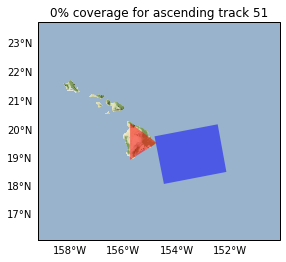

/home/gert/anaconda3/envs/stereoid/lib/python3.7/site-packages/cartopy/io/img_tiles.py:320: UserWarning: The StamenTerrain class was deprecated in v0.17. Please use Stamen('terrain-background') instead.
  "The StamenTerrain class was deprecated in v0.17. "


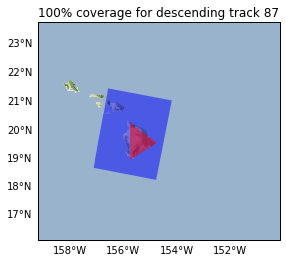

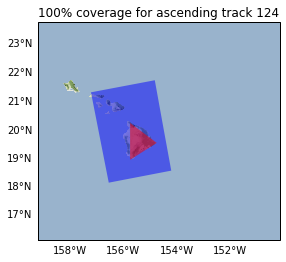

Summary statistics for Sentinel-1 search:
Stack for ascending track 051 contains 4 images with 0% coverage of area of interest
Stack for descending track 087 contains 3 images with 100% coverage of area of interest
Stack for ascending track 124 contains 3 images with 100% coverage of area of interest

Full list of images for track 051:
2018-04-27T04:22:40 with a coverage of 0% consists of SAR products:
          S1A_IW_SLC__1SDV_20180427T042212_20180427T042240_021648_02553A_E912
2018-05-03T04:21:58 with a coverage of 0% consists of SAR products:
          S1B_IW_SLC__1SDV_20180503T042130_20180503T042158_010752_013A4C_BB7B
2018-05-09T04:22:40 with a coverage of 0% consists of SAR products:
          S1A_IW_SLC__1SDV_20180509T042212_20180509T042240_021823_025AC8_C22E
2018-05-15T04:21:59 with a coverage of 0% consists of SAR products:
          S1B_IW_SLC__1SDV_20180515T042131_20180515T042159_010927_013FF4_8F07

Full list of images for track 087:
2018-04-23T16:15:51.511144 with a coverage

In [2]:


# Track and data type of Sentinel data
mode = 'IW'
product_type = 'SLC'
polarisation = ['VV','VH']

# First we check using a time window
earthquake_date = datetime.datetime(year=2018, month=5, day=4, hour=22)
time_window = datetime.timedelta(days=12)

find_track = DownloadSentinel(date=earthquake_date, time_window=time_window,
                              shape=study_area.shape, sensor_mode=mode,
                              polarisation=polarisation)

find_track.sentinel_search_ASF()
find_track.summarize_search_results(plot_cartopy=True, buffer=2)


After selection of the desired track we can start the actual download of the images. In our case we use track 087.

This will download our data automatically to our radar database. Additionally, it will download the precise orbit files.
These files are created within a few weeks after the data acquisition and define the satellite orbit within a few cm
accuracy. These orbits are necessary to accurately define the positions of the radar pixels on the ground later on
in the processing.

In [3]:
from rippl.processing_templates.InSAR_processing import InSAR_Processing

# Create the list of the 4 different stacks.
track_no = 87
stack_name = 'Hawaii_may_2018_descending'
# For every track we have to select a master date. This is based on the search results earlier.
# Choose the date with the lowest coverage to create an image with only the overlapping parts.
start_date = datetime.datetime(year=2018, month=4, day=22)
end_date = datetime.datetime(year=2018, month=5, day=8)
reference_date = datetime.datetime(year=2018, month=5, day=5)

# Number of processes for parallel processing. Make sure that for every process at least 2GB of RAM is available
no_processes = 6
s1_processing = InSAR_Processing(processes=no_processes, stack_name=stack_name)
s1_processing.download_sentinel_data(start_date=start_date, end_date=end_date, track=track_no,
                                     polarisation=polarisation, shapefile=study_area.shape, data=True, source='ASF')
s1_processing.create_sentinel_stack(start_date=start_date, end_date=end_date, reference_date=reference_date,
                                    cores=no_processes, track_no=track_no, polarisation=polarisation,
                                    shapefile=study_area.shape, mode=mode, product_type=product_type)

# Finally load the stack itself. If you want to skip the download step later, run this line before other steps!
s1_processing.read_stack(start_date=start_date, end_date=end_date)
s1_processing.create_coverage_shp_kml_geojson()

searching for new POE files
https://scihub.copernicus.eu/gnss/search/?q=producttype:AUX_POEORB platformname:Sentinel-1 beginPosition:[2018-04-22T00:00:00Z TO 2018-05-08T00:00:00Z] endPosition:[2018-04-22T00:00:00Z TO 2018-05-08T00:00:00Z]&format=json
found 28 OSV results
/mnt/external/rippl_tutorial_test/orbit_database/Sentinel-1/precise/S1B_OPER_AUX_POEORB_OPOD_20210313T003512_V20180428T225942_20180430T005942.EOF
/mnt/external/rippl_tutorial_test/orbit_database/Sentinel-1/precise/S1B_OPER_AUX_POEORB_OPOD_20210312T234344_V20180425T225942_20180427T005942.EOF
/mnt/external/rippl_tutorial_test/orbit_database/Sentinel-1/precise/S1B_OPER_AUX_POEORB_OPOD_20210313T021503_V20180504T225942_20180506T005942.EOF
/mnt/external/rippl_tutorial_test/orbit_database/Sentinel-1/precise/S1B_OPER_AUX_POEORB_OPOD_20210312T225246_V20180422T225942_20180424T005942.EOF
/mnt/external/rippl_tutorial_test/orbit_database/Sentinel-1/precise/S1B_OPER_AUX_POEORB_OPOD_20210313T015827_V20180503T225942_20180505T005942.EO

To define the location of the radar pixels on the ground we need the terrain elevation. Although it is possible to 
derive terrain elevation from InSAR data, our used Sentinel-1 dataset is not suitable for this purpose. Therefore, we
download data from an external source to create a digital elevation model (DEM). In our case we use SRTM data. 

However, to find the elevation of the SAR data grid, we have to resample the data to the radar grid first to make it
usable. This is done in the next steps.

In [4]:
# Some basic settings for DEM creation.
dem_buffer = 0          # Buffer around radar image where DEM data is downloaded
dem_rounding = 0        # Rounding of DEM size in degrees
min_height = -100       # Expected minimum elevation in area of interest (take geoid into account!)
max_height = 4300       # Expected maximum elevation in area of interest
dem_type = 'SRTM1'      # DEM type of data we download (SRTM1, SRTM3 and TanDEM-X are supported)

# Define both the coordinate system of the DEM, download the needed tiles and import the DEM
s1_processing.create_dem_coordinates(dem_type=dem_type, buffer=dem_buffer, rounding=dem_rounding,
                                     min_height=min_height, max_height=max_height)
s1_processing.download_external_dem(n_processes=no_processes, dem_type=dem_type)

All needed SRTM DEM files already downloaded.
Generating DEM input size from input grid
Process already finished
Generating DEM input size from input grid
Process already finished
Generating DEM input size from input grid
Process already finished
Generating DEM input size from input grid
Process already finished
Generating DEM input size from input grid
Process already finished
Generating DEM input size from input grid
Process already finished
Generating DEM input size from input grid
Process already finished
Generating DEM input size from input grid
Process already finished
Generating DEM input size from input grid
Process already finished
Generating DEM input size from input grid
Process already finished
Generating DEM input size from input grid
Process already finished
Generating DEM input size from input grid
Process already finished
Generating DEM input size from input grid
Process already finished
Generating DEM input size from input grid
Process already finished
Generating DEM i

Using the obtained elevation model the exact location of the radar pixels in cartesian (X,Y,Z) and geographic (Lat/Lon)
can be derived. This is only done for the reference SLC. This process is referred to as geocoding.

In [5]:
# Geocoding of image
s1_processing.geocode_calc_geometry(dem_type=dem_type)

SRTM1 already exists but overwrite is False. Keeping the old settings
Processing pipeline block 1 out of 1
Start time block 1 is 2023-07-26 16:46:41.933420
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping pro

The information from the geocoding can directly be used to find the location of the reference grid pixels in the secondary
grid images. This process is called coregistration. Because the orbits are not exactly the same with every satellite 
overpass but differ hundreds to a few thousand meters every overpass, the grids are slightly shifted with respect to 
each other. These shift are referred to as the spatial baseline of the images. To correctly overlay the reference and secondary
images the software coregisters and resamples to the reference grid.

To do so the following steps are done:
1. Coregistration of secondary to reference image
2. Deramping the doppler effects due to TOPs mode of Sentinel-1 satellite
3. Resampling of secondary image
4. Reramping resampled secondary image.

Due to the different orbits of the reference and secondary image, the phase of the radar signal is also shifted. We do not 
know the exact shift of the two image, but using the geometry of the two images we can estimate the shift of the phase
between different pixels. Often this shift is split in two contributions:
1. The flat earth phase. This phase is the shift in the case the earth was a perfect ellipsoid
2. The topographic phase. This is the phase shift due to the topography on the ground.
In our processing these two corrections are done in one go.

In [6]:
# Next step applies resampling and phase correction in one step.
# Polarisation
s1_processing.coregister_resample(polarisation=polarisation)

Processing pipeline block 1 out of 1
Start time block 1 is 2023-07-26 16:46:45.774212
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to d

Before we create an interferogram the different bursts are first mosaicked. This can only be done after resampling as
it is influenced by the phase ramps in TOPs mode of Sentinel-1. 

The independent SAR grids can now be visualized using the amplitude of the resampled data. In our case these are 
written as .tiff files for a georeferenced grid of the region. The data can be visualized using QGIS. The amplitude power
is given in dB. 

In [7]:
# Resolution of output georeferenced grid
dlat = 0.001
dlon = 0.001

# The actual creation of the calibrated amplitude images
s1_processing.create_ml_coordinates(name='geographic_100m', coor_type='geographic', dlat=dlat, dlon=dlon, buffer=dem_buffer, rounding=dem_rounding, min_height=min_height, max_height=max_height)
# To calculate the calibrated amplitudes we need the incidence angle.
s1_processing.geocode_calc_geometry_multilooked(ml_name='geographic_100m')
s1_processing.calc_calibrated_amplitude(polarisation=polarisation, ml_name='geographic_100m')

# Create the output tiffs
s1_processing.create_output_geotiffs('calibrated_amplitude', ml_name='geographic_100m')

Processing pipeline block 1 out of 1
Start time block 1 is 2023-07-26 16:46:51.649512
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Finished processing pipeline block 1 out of 1
Finished block 1 in 0:00:00.161400
geographic_100m already exists but overwrite is False. Keeping the old settings
Processing pipeline block 1 out of 1
Start time block 1 is 2023-07-26 16:46:53.896404
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finish

We can do the same thing using a projected grid with distances in meters. In this case we use the oblique mercator
projection. This projection can be configured in such a way that the grid follows the orbit of the satellite, which has
the advantage that the final product will be smaller, has less empty spaces and respects the satellite azimuth and
range directions.

In [8]:
# Resolution of output georeferenced grid
dy = 100
dx = 100

# The actual creation of the calibrated amplitude images
s1_processing.create_ml_coordinates(name='mercator_100m', coor_type='projection', oblique_mercator=True, dx=dx, dy=dy, buffer=dem_buffer, rounding=dem_rounding, min_height=min_height, max_height=max_height, overwrite=True)
# To calculate the calibrated amplitudes we need the incidence angle.
s1_processing.geocode_calc_geometry_multilooked(ml_name='mercator_100m')
s1_processing.calc_calibrated_amplitude(polarisation=polarisation, ml_name='mercator_100m')

# Create the output geotiff files
s1_processing.create_output_geotiffs('calibrated_amplitude', ml_name='mercator_100m')

Processing pipeline block 1 out of 1
Start time block 1 is 2023-07-26 16:47:00.521070
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Finished processing pipeline block 1 out of 1
Finished block 1 in 0:00:00.197766
mercator_100m already exists but overwrite is False. Keeping the old settings
Processing pipeline block 1 out of 1
Start time block 1 is 2023-07-26 16:47:02.670726
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished

After moasicing we can create the interferogram between the different images. This image is also multilooked and 
outputted as a .tiff file. This can also be viewed in QGIS. Because the phase shift between different pixels is often 
larger than two pi radians or a wavelength (56 mm for C-band), this image will show fringes going from -pi to pi and 
starting at -pi again. 
Using the same multilooking grid also a coherence grid is created, which indicates the quality of the obtained phases.

In [9]:
# Create interferograms meta data
s1_processing.create_interferogram_network(max_temporal_baseline=30)

# Resolution of output georeferenced grid
dy = 100
dx = 100

# The actual creation of the calibrated amplitude images
s1_processing.create_ml_coordinates(name='mercator_100m', coor_type='projection', oblique_mercator=True, dx=dx, dy=dy, buffer=dem_buffer, rounding=dem_rounding, min_height=min_height, max_height=max_height, overwrite=True)

# Create interferograms and coherence
s1_processing.calc_interferogram_coherence(polarisation=polarisation, ml_name='mercator_100m')
s1_processing.calc_interferogram_coherence(polarisation=polarisation, ml_name='geographic_100m')

# Create output geotiffs
s1_processing.create_output_geotiffs('coherence', ml_name='mercator_100m')
s1_processing.create_output_geotiffs('interferogram', ml_name='mercator_100m')
s1_processing.create_output_geotiffs('coherence', ml_name='geographic_100m')
s1_processing.create_output_geotiffs('interferogram', ml_name='geographic_100m')

mercator_100m already exists but overwrite is False. Keeping the old settings
Processing pipeline block 1 out of 1
Start time block 1 is 2023-07-26 16:47:13.876591
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skip

To go to absolute differences the data is therefore unwrapped. The result of this is given in the unwrapped geotiff.
For the unwrapping we use the program snaphu. With a resolution of 100 meters the unwrapping can take quite some time.
If you want to speed up the unwrapping you could go for larger grid cells.

In [11]:
# To do unwrapping we use the program Snaphu. For high resolution images this can take a very long time.
# Therefore, we change the resolution, to create a higher number of looks and more stable
# interferometric phase signal.
dy = 200
dx = 200

# The actual creation of the calibrated amplitude images
s1_processing.create_ml_coordinates(name='mercator_200m', coor_type='projection', oblique_mercator=True, dx=dx, dy=dy, buffer=dem_buffer, rounding=dem_rounding, min_height=min_height, max_height=max_height, overwrite=True)
s1_processing.geocode_calc_geometry_multilooked(ml_name='mercator_200m')
s1_processing.calc_calibrated_amplitude(polarisation=polarisation, ml_name='mercator_200m')
s1_processing.calc_interferogram_coherence(polarisation=polarisation, ml_name='mercator_200m')

s1_processing.unwrap(polarisation, ml_name='mercator_200m')
s1_processing.create_output_geotiffs('unwrap', ml_name='mercator_200m')

Processing pipeline block 1 out of 1
Start time block 1 is 2023-07-26 16:51:19.664578
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Finished processing pipeline block 1 out of 1
Finished block 1 in 0:00:00.180292
mercator_200m already exists but overwrite is False. Keeping the old settings
Processing pipeline block 1 out of 1
Start time block 1 is 2023-07-26 16:51:21.871472
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished or no data that should be saved to disk after processing.
Skipping processing. Process already finished

LookupError: reference_slc already exists but overwrite is False

In [ ]:
# Create some images of the ifg / no looks / incidence angles / unwrapped image / coherence / cal
# amplitude

# Create images using cartopy
s1_processing.plot_figures(process_name='calibrated_amplitude', variable_name='calibrated_amplitude_db',
                           margins=-0.25, ml_name='mercator_200m', cmap='Greys_r',
                           title='Calibrated Amplitude', cbar_title='dB')
s1_processing.plot_figures(process_name='intensity', variable_name='number_of_samples',
                           margins=-0.25, ml_name='mercator_200m', cmap='Greys_r',
                           title='Number of samples', cbar_title='#', quantiles=[0.001, 0.999])
s1_processing.plot_figures(process_name='dem', variable_name='dem',
                           margins=-0.25, ml_name='mercator_100m', cmap='terrain',
                           title='DEM', cbar_title='meters')
s1_processing.plot_figures(process_name='radar_geometry', variable_name='incidence_angle',
                           margins=-0.25, ml_name='mercator_100m', cmap='Greys_r',
                           title='Incidence Angle', cbar_title='degrees')
s1_processing.plot_figures(process_name='coherence', variable_name='coherence',
                           margins=-0.25, ml_name='mercator_100m', cmap='Greys_r',
                           title='Coherence', cbar_title='coherence')
s1_processing.plot_figures(process_name='interferogram', variable_name='interferogram',
                           margins=-0.25, ml_name='mercator_100m', cmap='jet',
                           title='Interferogram', cbar_title='radians', remove_sea=True)
s1_processing.plot_figures(process_name='interferogram', variable_name='interferogram',
                           margins=-0.25, ml_name='mercator_100m', cmap='jet',
                           title='Interferogram', cbar_title='radians', remove_sea=True)
s1_processing.plot_figures(process_name='unwrap', variable_name='unwrapped',
                           margins=-0.25, ml_name='mercator_200m', cmap='jet',
                           title='Unwrapped interferogram', cbar_title='meter', remove_sea=True,
                           factor=-0.0554657 / (np.pi * 2) / 2, linear_transparency=False,
                           dB_lims=[-18, 10], coh_lims=[0.05, 1])



This finishes the tutorial! In QGIS you can visualize the results of your processing.